# Visualization

## Qubit Visualization

What are the possible states a qubit can be in and how can we build up a visual cue to help us make sense of quantum states and their evolution?

We know our qubit can have two distinct states: $|0\rangle$ and $|1\rangle$. If these were the only two states, we could represent them as two vectors on a one-dimensional line (i.e., the z-axis in the image below). We also know that qubits can be in an equal superposition of states: $|+\rangle$ and $|-\rangle$. In order to capture all of the states in equal superposition, we will need a 2D plane (i.e., the $xy$-plane in the image below). If you dive deeper, you will learn about the existence of other states that will call for a 3D extension.

In general, a quantum state can be written in the form:

$$
|\psi\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + e^{i\varphi}\sin\left(\frac{\theta}{2}\right)|1\rangle
$$

where $\theta$ is a real number between $0$ and $\pi$ and $\varphi$ is a real value between $0$ and $2\pi$. For example, the minus state, 

$$
|-\rangle = \frac{1}{\sqrt{2}}|0\rangle - \frac{1}{\sqrt{2}}|1\rangle,
$$

can be rewritten as:

$$
|-\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + e^{i\varphi}\sin\left(\frac{\theta}{2}\right)|1\rangle \quad \text{with } \theta = \frac{\pi}{2} \text{ and } \varphi = \pi.
$$

This can be visualized in the image below as a unit vector pointing in the direction of the negative $x$-axis.

Using spherical coordinates, it is possible to depict all the possible states of a single qubit on a sphere. This is called a Bloch sphere.

![Bloch Sphere](#)

Let us try to showcase the functionality to render such a 3D representation with CUDA-Q. First, let us define a single-qubit kernel that returns a different state each time. This kernel uses random rotations.

**Note:** CUDA-Q uses the QuTiP library to render Bloch spheres. The following code will throw an error if QuTiP is not installed.

In [1]:
# install `qutip` in the current Python kernel. Skip this if `qutip` is already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    print("\nNew libraries have been installed. Please restart your kernel!")


Tools not found, installing. Please restart your kernel after this is done.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.5 MB/s eta 0:00:00
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 56.1 MB/s eta 0:00:00a 0:00:01

New libraries have been installed. Please restart your kernel!


In [2]:
import cudaq
import numpy as np

## Retry the subsequent cells by setting the target to density matrix simulator.
# cudaq.set_target("density-matrix-cpu")


@cudaq.kernel
def kernel(angles: np.ndarray):
    qubit = cudaq.qubit()
    rz(angles[0], qubit)
    rx(angles[1], qubit)
    rz(angles[2], qubit)

Next, we instantiate a random number generator, so we can get random outputs. We then create 4 random single-qubit states by using `cudaq.add_to_bloch_sphere()` on the output state obtained from the random kernel.

In [18]:
rng = np.random.default_rng(seed=11)
blochSphereList = []
for _ in range(4):
    angleList = rng.random(3) * 2 * np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel, angleList))
    blochSphereList.append(sph)


We can display the spheres with `cudaq.show()`. Show the first sphere:

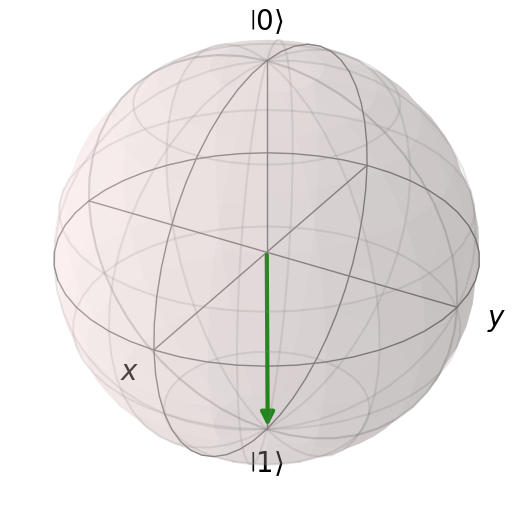

In [19]:
cudaq.show(blochSphereList[0])

We can also show multiple Bloch spheres side by side - simply set the `nrows` and `ncols` in the call to `cudaq.show()` accordingly. Make sure to have more spaces than spheres in your list, else it will throw an error! Let us show two spheres in a row:

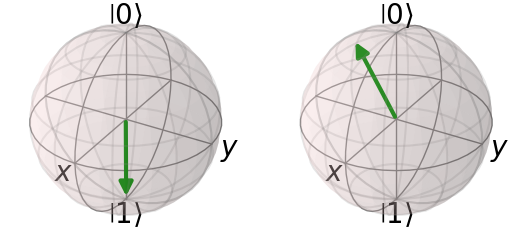

In [20]:
cudaq.show(blochSphereList[:2], nrows=1, ncols=2)

We can show them in a column too, if we want! Simply set the `nrows = 2` and `ncols = 1`.

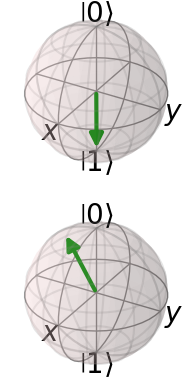

In [21]:
cudaq.show(blochSphereList[:2], nrows=2, ncols=1)

Can we show the entire list of 4 Bloch spheres we created? Absolutely!

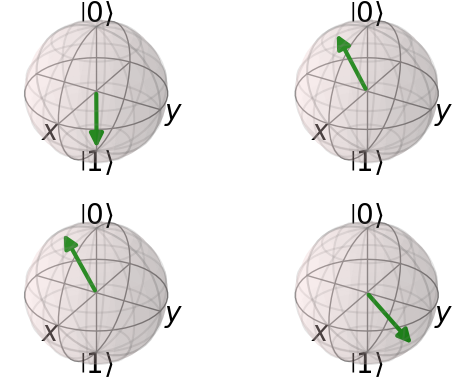

In [22]:
cudaq.show(blochSphereList[:], nrows=2, ncols=2)

What if we had to add multiple vectors to a single Bloch sphere? CUDA-Q uses the [QuTiP](https://www.qutip.org/) toolbox to construct Bloch spheres. We can then add multiple states to the same Bloch sphere by passing the sphere object as an argument to `cudaq.add_to_bloch_sphere()`.

In [23]:
import qutip

rng = np.random.default_rng(seed=47)
blochSphere = qutip.Bloch()
for _ in range(10):
    angleList = rng.random(3) * 2 * np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel, angleList), blochSphere)


This created a single Bloch sphere with 10 random vectors. Let us see how it looks.

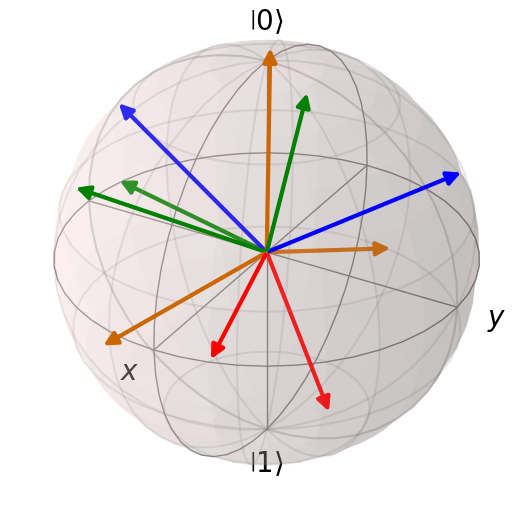

In [24]:
blochSphere.show()

Unfortunately, there is no such handy visualization for multi-qubit states. In particular, a multi-qubit state cannot be visualized as multiple Bloch spheres due to the nature of entanglement that makes quantum computing so powerful.

## Kernel Visualization¶

A CUDA-Q kernel can be visualized using the `cudaq.draw` API which returns a string representing the drawing of the execution path, in the specified format. ASCII (default) and LaTeX formats are supported.

In [25]:
@cudaq.kernel
def kernel_to_draw():
    q = cudaq.qvector(4)
    h(q)
    x.ctrl(q[0], q[1])
    y.ctrl([q[0], q[1]], q[2])
    z(q[2])

    swap(q[0], q[1])
    swap(q[0], q[3])
    swap(q[1], q[2])

    r1(3.14159, q[0])
    tdg(q[1])
    s(q[2])

In [26]:
print(cudaq.draw(kernel_to_draw))

     ╭───╮                  ╭───────────╮       
q0 : ┤ h ├──●────●────╳───╳─┤ r1(3.142) ├───────
     ├───┤╭─┴─╮  │    │   │ ╰───────────╯╭─────╮
q1 : ┤ h ├┤ x ├──●────╳───┼───────╳──────┤ tdg ├
     ├───┤╰───╯╭─┴─╮╭───╮ │       │      ╰┬───┬╯
q2 : ┤ h ├─────┤ y ├┤ z ├─┼───────╳───────┤ s ├─
     ├───┤     ╰───╯╰───╯ │               ╰───╯ 
q3 : ┤ h ├────────────────╳─────────────────────
     ╰───╯                                      



In [27]:
print(cudaq.draw('latex', kernel_to_draw))

\documentclass{minimal}
\usepackage{quantikz}
\begin{document}
\begin{quantikz}
  \lstick{$q_0$} & \gate{H} & \ctrl{1} & \ctrl{2} & \swap{1} & \swap{3} & \gate{R_1(3.142)} & \qw & \qw \\
  \lstick{$q_1$} & \gate{H} & \gate{X} & \ctrl{1} & \targX{} & \qw & \swap{1} & \gate{T^\dag} & \qw \\
  \lstick{$q_2$} & \gate{H} & \qw & \gate{Y} & \gate{Z} & \qw & \targX{} & \gate{S} & \qw \\
  \lstick{$q_3$} & \gate{H} & \qw & \qw & \qw & \targX{} & \qw & \qw & \qw \\
\end{quantikz}
\end{document}

